<div style="text-align: center;">
  <span style="color: blue; font-size: 36px; font-weight: bold;">
    Projeto Final: Butterworth Lowpass Filter
  </span><br>
  <span style="color: gray; font-size: 24px;">
    Autor: Luiz Felipe Barros Alves
  </span><br>
  <span style="color: gray; font-size: 20px;">
    Data: Abril de 2025
  </span>
</div>


## 1. Análise do sinal de entrada

- O sinal de entrada a ser amostrado pela ESP32 se trata de onda quadrada com frequência de $60Hz$. Tal como representado abaixo:

In [27]:
# Bibliotecas
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np

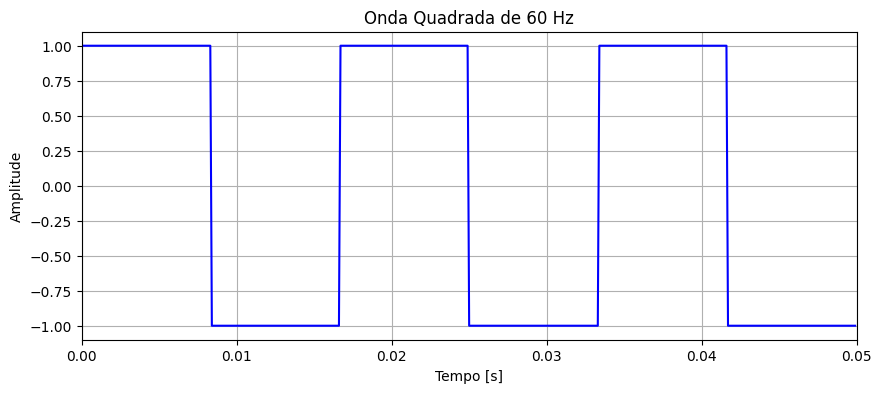

In [28]:
# Parâmetros
f = 60               # Frequência da onda (Hz)
t_final = 0.05       # Tempo total de simulação (segundos)
fs = 10000           # Frequência de amostragem (Hz)
t = np.linspace(0, t_final, int(fs * t_final), endpoint=False)

square_wave = signal.square(2 * np.pi * f * t) # Onda quadrada

plt.figure(figsize=(10, 4))
plt.plot(t, square_wave, color='blue')
plt.title('Onda Quadrada de 60 Hz')
plt.xlabel('Tempo [s]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.xlim(0, 0.05)  # Mostra apenas os primeiros ciclos
# plt.ylim(-1.5, 1.5)
plt.show()

- Análise das componentes de frequência da onda quadrada.

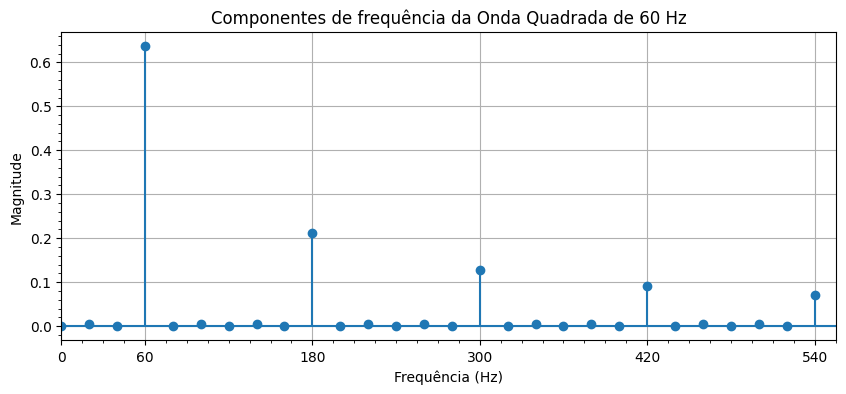

In [29]:
n = len(square_wave)
fft_vals = np.fft.fft(square_wave)
fft_freqs = np.fft.fftfreq(n, 1/fs)
fft_mag = np.abs(fft_vals) / n  # Normaliza a magnitude

plt.figure(figsize=(10, 4))
plt.stem(fft_freqs[:500], fft_mag[:500], basefmt='')
plt.title("Componentes de frequência da Onda Quadrada de 60 Hz")
plt.xlabel("Frequência (Hz)")
plt.ylabel("Magnitude")

xtics = [0 , 60, 3*60, 5*60, 7*60, 9*60]

plt.minorticks_on()
plt.xticks(xtics)
plt.grid(True)
plt.xlim(0, fs/18)
plt.show()


- A partir da análise espectral, contata-se que a primeira componenente harmônica do sinal possui uma frequência de $60Hz$. Para filtrar essa componente e obter na saída do microcontrolador uma senoide é necessário a implementação de um filtro passa-baixa.

## 2. Projeto do filtro passa-baixa de primeira ordem

2.1 Função de tranferência no tempo contínuo
- O filtro passa-baixa de primeira ordem possui a seguinte função de transferência:
$$H(s)=\frac{\omega_0}{s+\omega_0}$$

In [30]:
# Projeto do filtro
w0 = 2*np.pi*80; # frequencia de corte (rad/s)
num = w0        # numerador da função de transferência
den = [1,w0]    # denominador da função de transferência
lowPass = signal.TransferFunction(num,den) # Função de transferência

2.2 Função de tranferência no tempo discreto

- E importante notar que para implementar esse filtro em hardware é preciso realizar a discretização da função $H(s)$.
- Aqui é utilizado o Método de Tustin para aproximar a variável s: $s=$ $\frac{2}{\Delta t}$ $(\frac{1-z^{-1}}{1+z^{-1}})$.
- Os filtros IIR são caracterizados pelas equações:
$$
H(z) = \frac{\sum_{k=0}^{N-1} b_k z^{-k}}{1 + \sum_{k=1}^{M} a_k z^{-k}}
$$
- O sinal de saída é dado por:
$$
y[n] = a_1 y[n-1] + a_2 y[n-2] + \dots + b_0 x[n] + b_1 x[n-1] + \dots
$$


In [31]:
samplingFreq = 1e3 # Frequência de amostragem utilizada na ESP32
dt = 1.0/samplingFreq
discreteLowPass = lowPass.to_discrete(dt,method='gbt',alpha=0.5) # alpha = 1/2 Método de Tustin

In [32]:
b = discreteLowPass.num;
a = -discreteLowPass.den;
print(f"Coeficientes do filtro b_i: {b}")
print(f"Coeficientes do filtro a_i: {a[1:]}")

Coeficientes do filtro b_i: [0.20084864 0.20084864]
Coeficientes do filtro a_i: [0.59830271]


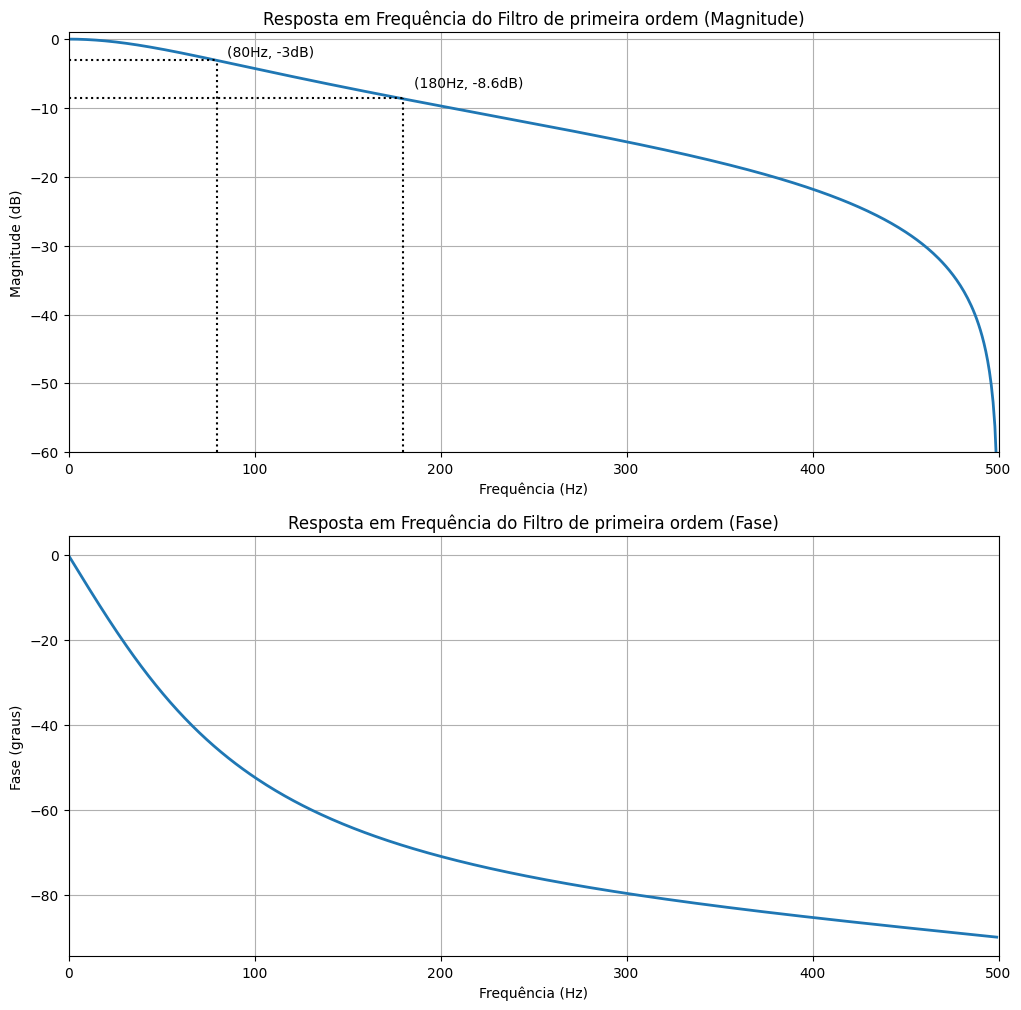

In [33]:
# Resposta em frequência do filtro discreto
f, h = signal.freqz(discreteLowPass.num, discreteLowPass.den, fs=samplingFreq)

fig, axs  = plt.subplots(2, 1, figsize=(12, 12))
axs[0].plot(f, 20 * np.log10(abs(h)), lw=2)
axs[0].set_title('Resposta em Frequência do Filtro de primeira ordem (Magnitude)')
axs[0].set_xlabel('Frequência (Hz)')
axs[0].set_ylabel('Magnitude (dB)')
axs[0].set_ylim(-60, 1)
axs[0].set_xlim(0, 500)

axs[0].hlines(-3, 0, 80, ls=':', color='black')
axs[0].vlines(80, -60, -3, ls=':', color='black')
axs[0].text(85, -2.5, '(80Hz, -3dB)')

axs[0].hlines(-8.6, 0, 180, ls=':', color='black')
axs[0].vlines(180, -60, -8.6, ls=':', color='black')
axs[0].text(186, -7, '(180Hz, -8.6dB)')

axs[0].grid()

axs[1].plot(f, np.angle(h)*180/np.pi, lw=2)
axs[1].set_title('Resposta em Frequência do Filtro de primeira ordem (Fase)')
axs[1].set_xlabel('Frequência (Hz)')
axs[1].set_ylabel('Fase (graus)')
# axs[1].set_ylim(0, -60)
axs[1].set_xlim(0, 500)
axs[1].grid()

## 3. Projeto do filtro passa-baixa Butterworth segunda ordem

3.1 Função de tranferência no tempo contínuo
- O filtro passa-baixa Butterworth possui a seguinte função de transferência:
$$
H(s) = \frac{1}{\sum_{0}^{n} \beta_k s^k}
$$

onde o coeficiente é obtido de forma recursiva:

$$
\beta_{k+1} = \frac{\cos(k\gamma)}{\sin((k+1)\gamma)} \beta_k
$$

sendo \( $\beta_0 = 1$ \) and \( $\gamma = \frac{\pi}{2n}$ \).

O Butterworth de ordem $n$ com frequência de corte $\omega_c$ é dado por:

$$
B_n(s) = \sum_{k=0}^{n} c_k s^k
$$

com \( $c_k = \frac{\beta_k}{\omega_c^k}$ \).

Assim para um filtro de segunda ordem, tem-se:

$$
H(s) = \frac{1}{c_0 + c_1 s + c_2 s^2}
$$

com \( $c_k = \frac{\beta_k}{\omega_c^k}$ \). Com isso, para n=2 os coeficientes são:

$$
\beta_0 = 1 \quad \beta_1 = \sqrt{2} \quad \beta_2 = 1
$$

In [34]:
# Projeto do Filtro
wc = 2*np.pi*80 # Frequência de corte
n = 2           # Ordem do filtro

beta = np.zeros(n+1)
gamma = np.pi / (2.0*n)
beta[0] = 1; # Primeiro coeficiente é igual 1
for k in range(0, n):
    beta[k+1] = ( np.cos(k*gamma)/np.sin((k+1)*gamma) ) * beta[k]

print(f'Coeficientes do filtro beta_i: {beta}')

# Ajustando de acordo com a frequência de corte
c = np.zeros(n+1)
for k in range(0, n+1):
    c[n-k] = beta[k]/pow(wc,k)

print(f'Coeficientes do filtro c_k: {c}')

Coeficientes do filtro beta_i: [1.         1.41421356 1.        ]
Coeficientes do filtro c_k: [3.95785874e-06 2.81348849e-03 1.00000000e+00]


b = [0.04452675 0.08905349 0.04452675]
a = [ 1.32079107 -0.49889805]


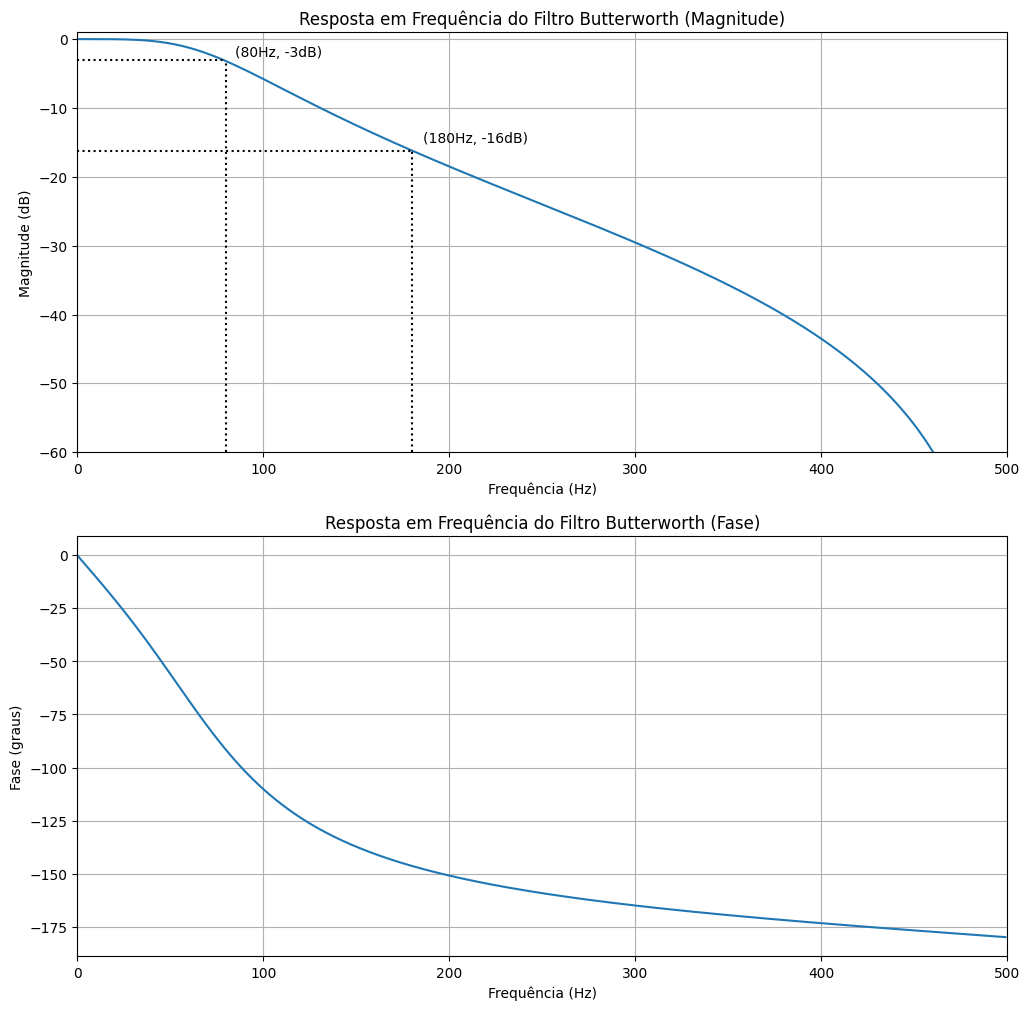

In [35]:
num_b = [1];      # Numerador da função de transferência
den_b = c;        # Denominador da função de transferência
lowPass_b = signal.TransferFunction(num_b,den_b) # Função de Transferência
discreteLowPass_b = lowPass_b.to_discrete(dt,method='gbt',alpha=0.5)
print(f'b = {discreteLowPass_b.num}')
print(f'a = {-discreteLowPass_b.den[1:]}')

f_b, h_b = signal.freqz(discreteLowPass_b.num, discreteLowPass_b.den, fs=samplingFreq)

fig, axs  = plt.subplots(2, 1, figsize=(12, 12))
axs[0].plot(f_b, 20 * np.log10(abs(h_b)))
axs[0].set_title('Resposta em Frequência do Filtro Butterworth (Magnitude)')
axs[0].set_xlabel('Frequência (Hz)')
axs[0].set_ylabel('Magnitude (dB)')
axs[0].set_ylim(-60, 1)
axs[0].set_xlim(0, 500)

axs[0].hlines(-3, 0, 80, ls=':', color='black')
axs[0].vlines(80, -60, -3, ls=':', color='black')
axs[0].text(85, -2.5, '(80Hz, -3dB)')

axs[0].hlines(-16.2, 0, 180, ls=':', color='black')
axs[0].vlines(180, -60, -16, ls=':', color='black')
axs[0].text(186, -15, '(180Hz, -16dB)')

axs[0].grid()

axs[1].plot(f_b, np.angle(h_b)*180/np.pi)
axs[1].set_title('Resposta em Frequência do Filtro Butterworth (Fase)')
axs[1].set_xlabel('Frequência (Hz)')
axs[1].set_ylabel('Fase (graus)')
axs[1].set_xlim(0, 500)
axs[1].grid()